# Project recommendations for repeat donors

Here, we are interested in analyzing a dataset posted by DonorsChoose.org, an organization that matches requests (projects) from public school teachers with individual donors.  The goal of this project is to use natural language features from the project descriptions in order to recommend specific classroom requests to donors with many prior donations.

In contrast to many of the datasets hosted on kaggle, there is no withheld test data or evaluation metric, so justifying the effectiveness of analysis is part of the project.  This problem is also a nice example of using "data science for good" to improve a non-profit in the education space. See https://www.kaggle.com/donorschoose/io for the data files.

The first step for our analysis is to load the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as math

# 1.1m rows
projects_ff = pd.read_csv('Projects.csv')
# 4.6m rows
donations_ff = pd.read_csv('Donations.csv')
# Some donations were missing valid project IDs...
df = donations_ff.merge(projects_ff, on="Project ID", how="inner")
df.head(3)

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,School ID,Teacher ID,Teacher Project Posted Sequence,...,Project Need Statement,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,...,My students need a cart to help us manage our ...,Music & The Arts,Music,Grades 6-8,Other,529.68,2016-05-13,2016-09-12,Fully Funded,2016-08-23
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,...,My students need a cart to help us manage our ...,Music & The Arts,Music,Grades 6-8,Other,529.68,2016-05-13,2016-09-12,Fully Funded,2016-08-23
2,000009891526c0ade7180f8423792063,18a234b9d1e538c431761d521ea7799d,0b0765dc9c759adc48a07688ba25e94e,Yes,20.00,3,2016-06-06 14:08:46,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,...,My students need a cart to help us manage our ...,Music & The Arts,Music,Grades 6-8,Other,529.68,2016-05-13,2016-09-12,Fully Funded,2016-08-23


In order to cut down on memory/time, we can take a smaller random sample for testing and development.

In [2]:
## REDUCED SIZE FOR TESTING/DEVELOPMENT
#donations = df.sample(n=100000)[['Project ID', 'Donation ID', 'Donor ID', 'Donation Amount', 'Donation Received Date']]
donations = df[['Project ID', 'Donation ID', 'Donor ID', 'Donation Amount', 'Donation Received Date']]

projects = projects_ff.loc[ projects_ff["Project ID"].isin(donations["Project ID"]) ].copy()
projects = projects.reset_index(drop = True)

print(" loaded", len(donations), "donations and", len(projects), "projects.")

 loaded 4614113 donations and 873849 projects.


The donation amounts vary widely and are dominated by small-dollar donations, so we use a log transform to smooth them out.

Before smoothing:


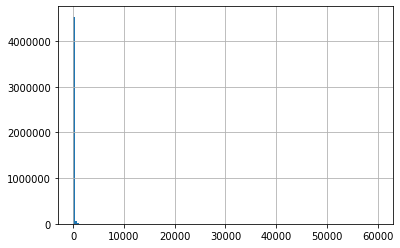

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


After smoothing:


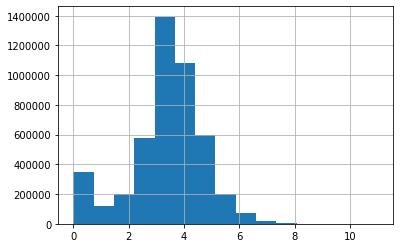

In [3]:
print("Before smoothing:")
donations["Donation Amount"].hist(bins=150)
plt.show()

# smooth out the donation amounts...
donations["Donation Amount"] = donations["Donation Amount"].apply(lambda x : math.log(1+x))

print("After smoothing:")
donations["Donation Amount"].hist(bins=15)
plt.show()

The basic structure of the data is that each **donor** typically interacts with several **projects**.  Each interaction is a **donation**.  We split the set of donations into training and test sets.  Our hope is to build a model using the **training set** that can accurately predict donations (for a particular donor) from the **test set**.

In [4]:
##
## Split the donations
##
from sklearn.model_selection import train_test_split 

donations_train, donations_test = train_test_split(donations, test_size=0.5)
print(len(donations_train), len(donations_test))

2307056 2307057


Next we build a list of donors ranked by the number of projects to which they have each contributed.  We broke down the number of projects they contributed to in terms of training (which we view as past projects) and test (which we view as future projects that we would like to predict).

In [5]:
##
## Find the top donors (by number of projects)
##

MIN_FREQ = 3

top_donors = pd.DataFrame(donations_train['Donor ID'].value_counts())
top_donors.columns = ['freq']
top_donors['Donor ID'] = top_donors.index
top_donors = top_donors.loc[top_donors.freq >= MIN_FREQ]

td_test = pd.DataFrame(donations_test.merge( top_donors, on="Donor ID", how="inner" ).groupby("Donor ID")["Project ID"].count())
td_test.columns = ['test_freq']
td_test = td_test.loc[td_test.test_freq >= MIN_FREQ]

top_donors = top_donors.merge(td_test, on="Donor ID", how="inner")
top_donors[:25]

,freq,Donor ID,test_freq
0,9087,39df9399f5384334a42905bcf0acdcbf,8948
1,7137,237db43817f34988f9d543ca518be4ee,7181
2,5198,a0e1d358aa17745ff3d3f4e4909356f3,5262
3,4490,6f74ffb17cbb2b616b1eef06bd4acd0c,4501
4,3095,a1929a1172ad0b3d14bc84f54018c563,3223
5,3033,19f24640d9da49f6f8b4c9938c049591,2993
6,2744,24ecca49933c30a0beb83090591720c0,2756
7,2719,6a35a7514005c04f8520e5d8f7657d91,2690
8,2553,74f7db06bcd9557d1e992dc029db69cc,2488
9,2528,b51c76411b51751f45527c63c69ead9e,2507


We use the training data to create a **Project x Feature matrix** that is inferred (using the TF-IDF model) from the text of the Project Essay associated to each project.  This assigns to each project a **feature vector** whose dimensions are particular terms from the project essay with values given by weights that are proportional to term frequency (TF) and inversely proportional to document frequency (IDF).

In [6]:
#
# Model training
#

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

top_projects = donations.merge(top_donors[:25]).merge(projects)[["Project ID", "Donor ID", "Donation Amount", "Project Essay"]]

# Preprocessing of text data
textfeats = ["Project Essay"]
for cols in textfeats:
    top_projects[cols] = top_projects[cols].astype(str) 
    top_projects[cols] = top_projects[cols].astype(str).fillna('') # FILL NA
    top_projects[cols] = top_projects[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently 
text = pd.Series(top_projects["Project Essay"])

basic_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', stop_words='english')
tuned_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', stop_words='english', 
                                   max_df=0.04, max_features = 5000, ngram_range = (1,3) )    
    
vectorizer = tuned_vectorizer

PF_MATRIX = vectorizer.fit_transform(text)
tfidf_feature_names = vectorizer.get_feature_names()

project_row_to_id = dict(top_projects['Project ID'])
project_id_to_row = {value: key for key, value in project_row_to_id.items()}

PF_MATRIX

<142921x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 8234118 stored elements in Compressed Sparse Row format>

Here, we found 5000 relevant terms so each feature vector is 5000-dimensional.  To visualize this, we can take a 2-dimensional projection.  For the figure below, we sample 25,000 projects, project their feature vectors into 2-D space, and color the points so that different colors represent different donors.  While we could spend some more time fine-tuning the TF-IDF model, we can start to see some nice clustering and separation among groups of projects.

25001


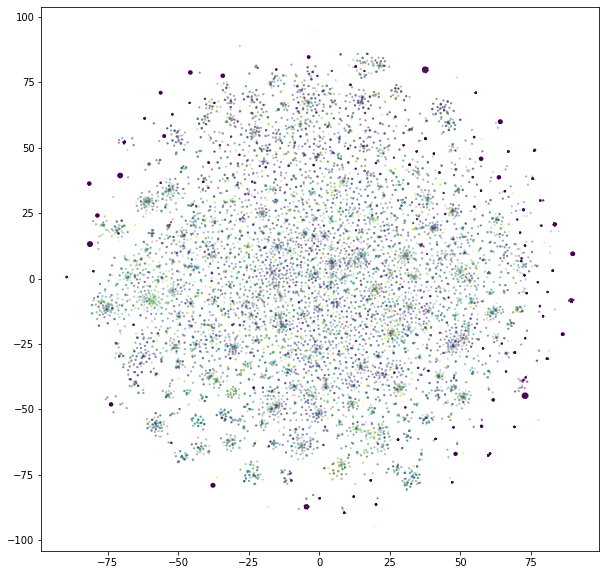

In [7]:
from sklearn.manifold import TSNE
import random
import scipy.sparse

donor_ids = list(top_donors[:25]['Donor ID'])

row = random.choice(range(PF_MATRIX.shape[0]))
X = PF_MATRIX[row]
colors = [donor_ids.index( top_projects.iloc[row]['Donor ID'] )]
for _ in range(25000):
    row = random.choice(range(PF_MATRIX.shape[0]))
    #X = np.vstack((X, PF_MATRIX[row].todense()))
    X = scipy.sparse.vstack((X, PF_MATRIX[row]))
    color = donor_ids.index( top_projects.iloc[row]['Donor ID'] )
    colors.append( color )
print (len(colors))

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
visual_df = pd.DataFrame(X_tsne, columns=['x', 'y'])
plt.figure(figsize=(10,10))
plt.scatter(visual_df['x'], visual_df['y'], c=colors, s=1.5, alpha=0.2)
#plt.scatter(visual_df['x'], visual_df['y'], c=colors, s=15, alpha=0.1)

## Recommendations

Next we build two recommendation systems.

The simpler one works as follows:  For each donor, we look up the projects they have contributed to in the past, and create a weighted average (using the smoothed donation amount) of the **feature vectors** for those projects.  To make recommendations, we then rank the projects in the **Project x Feature matrix** using cosine similarity with the donor vector we created.

This model works but has high bias because averaging feature vectors and using cosine similarity is a coarse way to create a donor profile.  (For example, a donor could have several project interests with the average landing near none of them.)  Therefore, we offer an alternative recommendation system that uses a simple neural network to rank projects for top donors.

To introduce this, recall that one of the most well-known early successes of neural networks is to the problem of classifying handwritten digits given a bitmap image (e.g. ImageNet).  Once the network is trained, it reads in individual pixel brightness values for a given image and outputs the probability of a match for each digit.

In our model, the "images" are project feature vectors, and the "digits" that classify each image are donor identifiers.  So our network takes feature vectors for projects as inputs.  Each project is labeled by a particular donor.  The network is trained to classify these **labeled feature vectors** by donor.  The output of the network is a list of probabilities for each donor, i.e. the probability that the given feature vector belongs to that donor.  To create recommendations for a particular donor, we pass each project's feature vector into the neural network and rank by the probabilities for that donor.

The following code creates and trains the neural network for the top 10 donors.

In [9]:
#
#  deep donor learning
#

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

def get_future_donation_rows(donor_id):
    donor_projects_test = donations_test.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    return list(donor_projects_test["Project ID"].map(project_id_to_row))

def get_past_donation_rows(donor_id):
    donor_projects_train = donations_train.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    return list(donor_projects_train["Project ID"].map(project_id_to_row))

LEARN_TOP = 10

X_train = []
y_train = []
X_valid = []
y_valid = []
donor_ids = list(top_donors[:LEARN_TOP]['Donor ID'])
for donor_id in donor_ids:
    for row in get_past_donation_rows(donor_id):
        X_train.append( PF_MATRIX[row].todense() )
        y_train.append( donor_ids.index(donor_id)  )

for donor_id in donor_ids:
    for row in get_future_donation_rows(donor_id):
        X_valid.append( PF_MATRIX[row].todense() )
        y_valid.append( donor_ids.index(donor_id)  )

X_train = np.array(X_train)
X_valid = np.array(X_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

X_train = X_train.reshape(X_train.shape[0], 5000).astype('float32')
X_valid = X_valid.reshape(X_valid.shape[0], 5000).astype('float32')
n_classes = LEARN_TOP
y_train = keras.utils.to_categorical(y_train, n_classes)
y_valid = keras.utils.to_categorical(y_valid, n_classes)

deep_donor_model = Sequential()
deep_donor_model.add(Dense(64, activation='sigmoid', input_shape=(5000,)))
deep_donor_model.add(Dense(LEARN_TOP, activation='softmax'))
deep_donor_model.summary()

deep_donor_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
deep_donor_model.fit(X_train, y_train, batch_size=64, epochs=18, verbose=1, validation_data=(X_valid, y_valid))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                320064    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 320,714
Trainable params: 320,714
Non-trainable params: 0
_________________________________________________________________
Train on 42584 samples, validate on 42549 samples
Epoch 1/18
42584/42584 [==============================] - 3s 80us/step - loss: 0.0751 - accuracy: 0.3440 - val_loss: 0.0674 - val_accuracy: 0.4619
Epoch 2/18
42584/42584 [==============================] - 3s 71us/step - loss: 0.0640 - accuracy: 0.4907 - val_loss: 0.0622 - val_accuracy: 0.4989
Epoch 3/18
42584/42584 [==============================] - 4s 92us/step - loss: 0.0594 - accuracy: 0.5283 - val_loss: 0.0593 - val_accuracy: 0.5207
Epoch 4/18
42584/42

Next we build the methods used in our recommendation systems.

The *recommend_for_shallow()* method uses feature vector averaging and cosine similarity, while the *recommend_for_deep()* method uses the trained neural network to infer donor profiles.

In [10]:
#
# Model definition
#

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

def get_project_profile_vector(proj_id):
    return PF_MATRIX[project_id_to_row[proj_id]]

def get_donor_profile_vector(donor_id):
    donor_projects = donations_train.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    weighted_average = 0
    total_weight = donor_projects["Donation Amount"].sum()
    for i in range(len(donor_projects)):
        projid, projam = donor_projects.iloc[i][["Project ID", "Donation Amount"]]
        pf_vector = PF_MATRIX[project_id_to_row[projid]]
        rel_weight = projam / total_weight
        weighted_average = weighted_average + pf_vector*rel_weight
    weighted_average = normalize(weighted_average.reshape(1, -1))  ## N.B. new
    return weighted_average

def get_random_donation_rows(n):
    return list(projects.sample(n).index)

def recommend_for_shallow( donor_rank ):
    donor_id = top_donors.iloc[donor_rank-1]['Donor ID']
    weighted_average = get_donor_profile_vector(donor_id)
    scores = pd.DataFrame(cosine_similarity(PF_MATRIX, weighted_average.reshape(1, -1), dense_output = True))
    scores.columns = ['score']
    scores.sort_values(by='score', ascending=False, inplace=True)
    scores['Project ID'] = scores.index.map(project_row_to_id)

    donor_projects = donations_train.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    scores['has donated'] = scores['Project ID'].isin(donor_projects['Project ID'])
    
    donor_projects_test = donations_test.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    scores['will donate'] = scores['Project ID'].isin(donor_projects_test['Project ID'])

    return scores

def recommend_for_deep( donor_rank ):
    donor_id = top_donors.iloc[donor_rank-1]['Donor ID']
    # recs from deep model
    scores = pd.DataFrame(deep_donor_model.predict(PF_MATRIX.todense()))
    scores.rename(columns={(donor_rank-1):'score'}, inplace=True)
    scores.sort_values(by='score', ascending=False, inplace=True)
    scores['Project ID'] = scores.index.map(project_row_to_id)
    scores

    donor_projects = donations_train.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    scores['has donated'] = scores['Project ID'].isin(donor_projects['Project ID'])
    
    donor_projects_test = donations_test.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    scores['will donate'] = scores['Project ID'].isin(donor_projects_test['Project ID'])

    return scores

def recommend_filtered( scores, top_n = 50, filter_projects = None ):
    if filter_projects != None:
        scores = scores.loc[scores.index.isin(filter_projects)] 

    return scores.head(top_n)

In order to evaluate the model, we create an experiment for each donor and project from the *test* set for that donor (which has not been used in training either of our models).  The experiment places the project that the donor actually contributed to among 99 other randomly selected projects and asks the recommendation system to rank the 100 projects.  We deem the experiment successful if the relevant project appears in the top 10 recommendations.  This is a measure of **recall** for our recommendation system.

In [11]:
# We ran two sets of tests, one used recommend_for_shallow to make recommendations while the other used recommend_for_deep...
TESTS_SHALLOW = []
TESTS_DEEP = []

In [17]:
#
# Model testing
#
import random

REP_SAMPLE_SIZE = 500

def recall_at(donor_rank, deep = True, N = 10):
    ranks = []
    the_recs = None
    if (deep == True):
        the_recs = recommend_for_deep( donor_rank )
    else:
        the_recs = recommend_for_shallow( donor_rank )
    donor_id = top_donors.iloc[donor_rank-1]['Donor ID']
    for proj in random.sample(get_future_donation_rows(donor_id), REP_SAMPLE_SIZE):
        one_out_of_99_exp = [ proj ]
        one_out_of_99_exp.extend( get_random_donation_rows(99) )
        recs = recommend_filtered(the_recs, N, one_out_of_99_exp)
        recs = recs.reset_index()
        try:
            rank = recs.loc[recs['index'] == proj].index[0]+1
            ranks.append(rank)
        except:
            ranks.append(-1)
    return len([ r for r in ranks if r > 0 and r <= 10 ]) / len(ranks)

recalls = []
recalld = []
for drank in range(1,11):
    rars = recall_at(drank, deep=False)
    rard = recall_at(drank, deep=True)
    print( rars, rard, "= recall@10 for top donor", drank )
    recalls.append( rars )
    recalld.append( rard )
print("Average recall@10 for top donors: ", sum(recalls)/len(recalls) )
print("Average recall@10 for top donors: ", sum(recalld)/len(recalld) )

0.996 1.0 = recall@10 for top donor 1
0.744 0.852 = recall@10 for top donor 2
0.822 0.922 = recall@10 for top donor 3
0.824 0.96 = recall@10 for top donor 4
0.748 0.876 = recall@10 for top donor 5
0.778 0.88 = recall@10 for top donor 6
0.86 0.944 = recall@10 for top donor 7
0.768 0.83 = recall@10 for top donor 8
0.74 0.9 = recall@10 for top donor 9
0.752 0.88 = recall@10 for top donor 10
Average recall@10 for top donors:  0.8032
Average recall@10 for top donors:  0.9044000000000001


In [18]:
TESTS_SHALLOW.append( recalls.copy() )
TESTS_DEEP.append( recalld.copy() )

We ran three trials (not shown) using each of the recommend_for_shallow and recommend_for_deep models to create recommendations.

Comparing these, we see that the deep model outperformed the basic model by about 10 percentage points.

tuned mean 0.9051999999999999  >= basic mean 0.8077333333333333


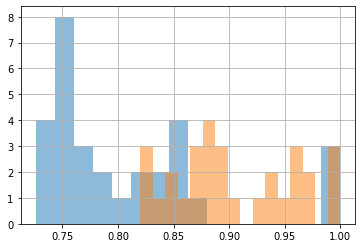

In [19]:
flatten = lambda l: [item for sublist in l for item in sublist]
tb = pd.Series(flatten(TESTS_SHALLOW))
tt = pd.Series(flatten(TESTS_DEEP))
tb.hist(alpha = 0.5, bins=16)
tt.hist(alpha = 0.5, bins=16)

print( "tuned mean", tt.mean(), " >= basic mean", tb.mean() )

# Future work

These results should be viewed as a baseline for improvement.  There are several other features beyond the "Project Essay" text that we could use to build a hybrid model.  For example, we could consider the state where the school is located or the grade level of the classroom.  There are also other hyper-parameters to tune for the TF-IDF feature extraction and neural network models.

Moreover, we have not yet included the smoothed donation amount in training our neural network model, and the architecture of our network is very simple.  It could be interesting to include convolutional layers applied directly to the project essay text.